In [19]:
import os
if not (os.path.isfile('data.zip') and os.path.isfile('data.zip')):
    !rm -rf model_discovery
    !rm -rf data
    import gdown
    # download source code
    gdown.download('https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_', output=None, quiet=False)
    # download data
    gdown.download('https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i', output=None, quiet=False)

    !unzip -qq data.zip
    !unzip -qq model_discovery.zip

Downloading...
From: https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_
To: /content/model_discovery.zip
100%|██████████| 11.9k/11.9k [00:00<00:00, 14.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i
To: /content/data.zip
22.5MB [00:00, 266MB/s]


replace data/activity_recognition/activity_recognition_full.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace model_discovery/benchmark.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [20]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import transferhub
from collections import Counter, defaultdict
from importlib import reload
from matplotlib import gridspec
from tqdm.notebook import trange, tqdm
from model_discovery import utils, l2lsh, my_timer

In [22]:
dir_path = ''
ar_data = np.load(dir_path + 'data/activity_recognition/activity_recognition_full.npy', allow_pickle=True).item()
ar_lsh_data = np.load(dir_path + 'data/activity_recognition/activity_recognition_sampled.npy', allow_pickle=True).item()


In [23]:
datasets = ['dsads_t', 'dsads_ra', 'dsads_la', 
            'dsads_rl', 'dsads_ll', 'oppo_b', 
            'oppo_rua', 'oppo_rla', 'oppo_lua',
            'oppo_lla', 'pamap_w', 'pamap_c',
            'pamap_a']

combinations = itertools.combinations(datasets,2)
combinations = list(combinations)

permutations = itertools.permutations(datasets,2)
permutations = list(permutations)

In [34]:
data = ar_lsh_data

## Validate the accuracy metrics with different r

In [37]:
# Construct ground truth
expect_result = defaultdict(set)
bins = 100

permutations = list(itertools.permutations(ar_lsh_data.keys(), 2))

for d1, d2 in tqdm(permutations, leave=False):
    data1 = utils.normalization(ar_lsh_data[d1].flatten())
    data2 = utils.normalization(ar_lsh_data[d2].flatten())
    prob1 = utils.data_to_probability(data1, bins=bins)
    prob2 = utils.data_to_probability(data2, bins=bins)

    jsd = utils.jensen_shannon_divergence(prob1, prob2)
    
    # Construct the ground truth if JS-Divergence is small than 0.1
    if jsd < 0.1: 
        expect_result[d1].add(d2)

In [38]:
def l2lsh_with_data(bins, r, num_k, num_l, data, seed=None):
    """Create a L2LSH object with given parameters, then insert the data 
    into the object.
    
    Args:
        bins (int): number of bins
        r (float): r is a real positive number
        num_l (int, optional): number of band,
            default=40
        num_k (int, optional): number of concatenated hash function, 
            default=4
        data (np.array): data input
    """
    lsh = l2lsh.L2LSH(bins, r=r, num_k=num_k, num_l=num_l, seed=seed)
    # Insert all data into lsh hash table
    for key in data.keys():
        prob = utils.data_to_probability(data[key], bins)
        sqrt_prob = np.sqrt(prob).reshape(-1, 1)      
        lsh.insert(sqrt_prob, key)
        
    return lsh


Accuracy Metrics

$Precision=\frac{Intercetion \ of \ queried \ result \ and \ ground \ truth}{Queried \ result}$

$Recall=\frac{Intercetion \ of \ queried \ result \ and \ ground \ truth}{Ground \ truth}$

$Signal Noisy Rate(SNR)=\frac{Queried \ result \ after \ validation}{Queried \ result}$

## Tunning Parameter r

In [39]:
preci = []
recall = []
f1 = []
f05 = []
snr = []

r_range = np.arange(0.001, 2, 0.01)

for r in tqdm(r_range, leave=False):

    lsh = l2lsh_with_data(bins, r, num_k=11, num_l=46, data=data, seed=10)      

    # Query
    actual_result = defaultdict(set)    
    single_query_snr = 0
    
    for q in data.keys():          
        q_prob = utils.data_to_probability(data[q], bins=bins)
        q_sq_prob = np.sqrt(q_prob).reshape(-1, 1)
        query_result = lsh.query(q_sq_prob, threshold=0)
        # Remove itself
        query_result.remove(q)      
        # Manually validate the JS-Divergence to avoid false positive
        for c in query_result:
            c_prob = utils.data_to_probability(data[c], bins)
            if utils.jensen_shannon_divergence(q_prob, c_prob) < 0.1:
                actual_result[q].add(c)       
        
        single_query_snr += len(actual_result[q]) / len(query_result) if len(query_result) != 0 else 1   
    
    performance_matrix = utils.evaluation(actual_result, expect_result)
    preci.append(performance_matrix[0])
    recall.append(performance_matrix[1])
    f1.append(performance_matrix[2])
    f05.append(performance_matrix[3])
    snr.append(single_query_snr / len(data.keys()))

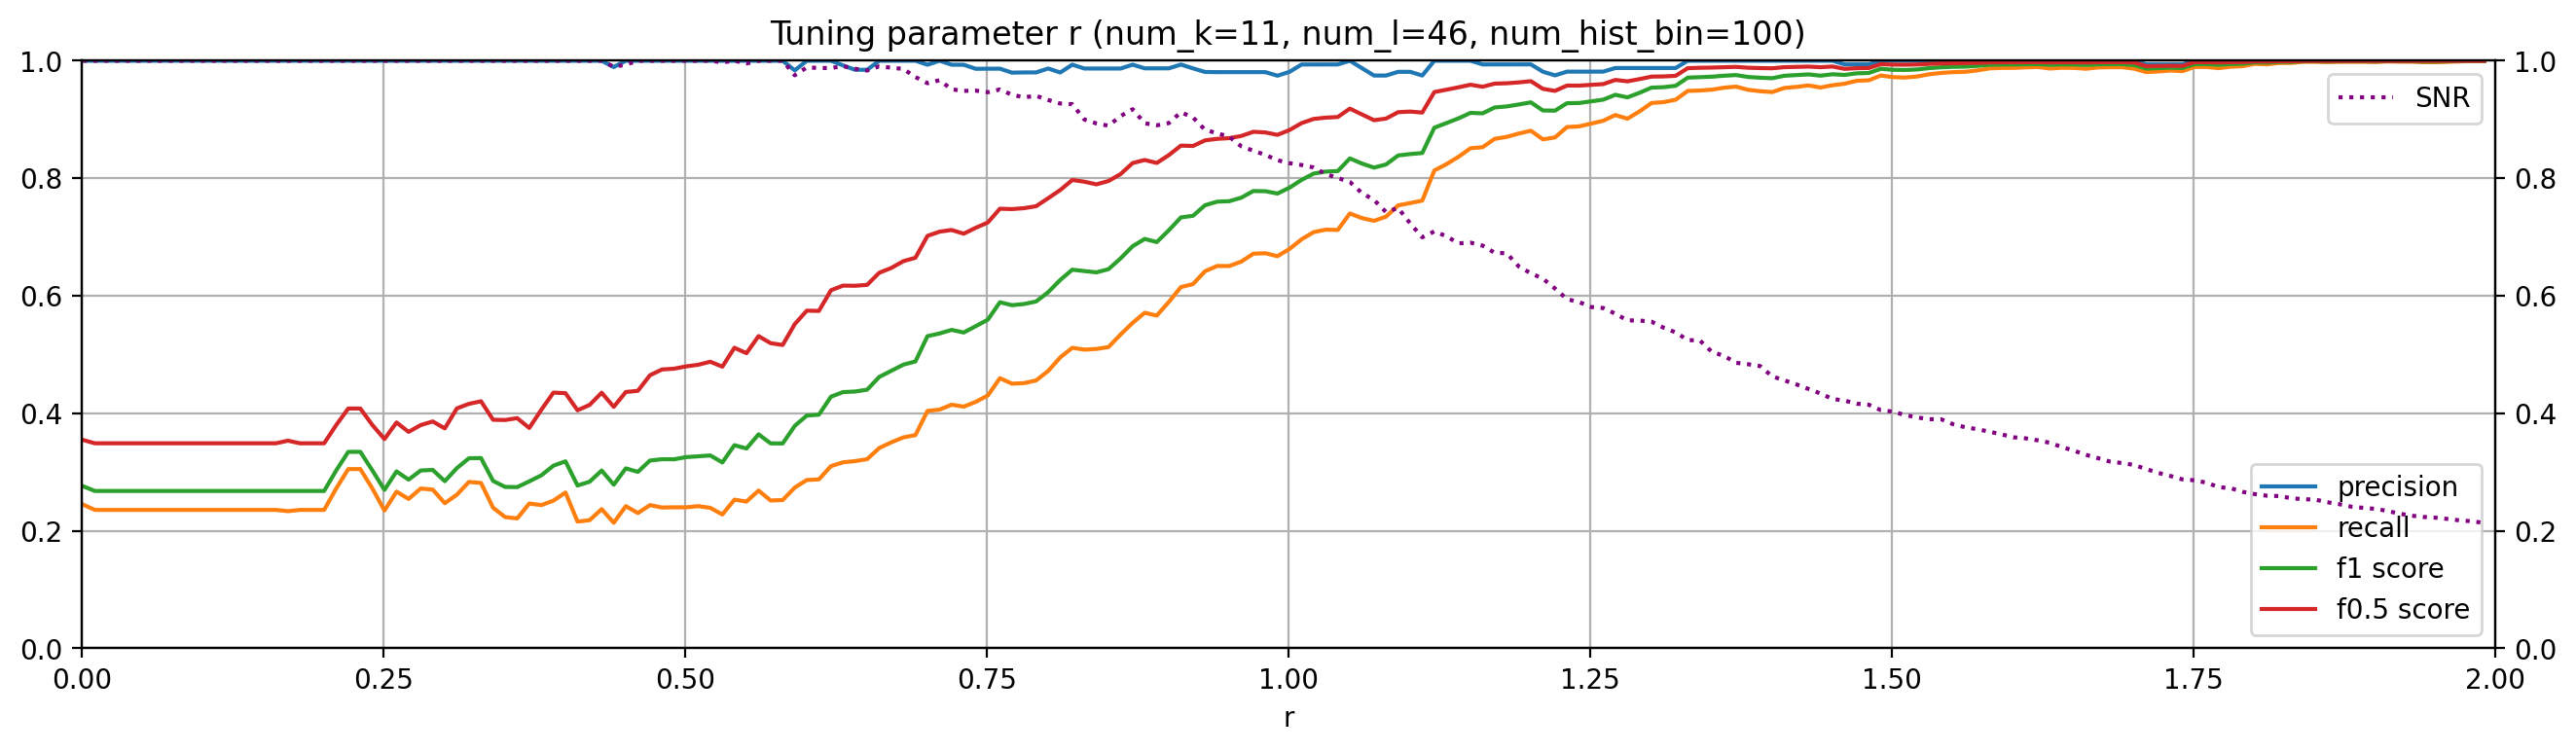

In [40]:
fig, ax1 = plt.subplots(figsize=(16,4), dpi=200)

x = r_range

ax1.plot(x, preci, label='precision')
ax1.plot(x, recall, label='recall')
ax1.plot(x, f1, label='f1 score')
ax1.plot(x, f05, label='f0.5 score')

ax1.set_xlabel('r')
ax1.legend(loc=4)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_xlim(0,2)

ax2 = ax1.twinx()
ax2.plot(x, snr, label='SNR', color='purple', linestyle=':')
ax2.set_ylim(0, 1)
ax2.legend()         

plt.title('Tuning parameter r (num_k=11, num_l=46, num_hist_bin=100)')
plt.show()

# fig.savefig('4_a.eps',dpi=300,format='eps')

## Tunning parameter K

In [41]:
preci = []
recall = []
f1 = []
f05 = []
snr = []

k_range = np.arange(1, 40, 1)

for k in tqdm(k_range, leave=False):

    lsh = l2lsh_with_data(bins, r=1.3, num_k=k, num_l=46, data=data, seed=10)      

    # Query
    actual_result = defaultdict(set)    
    single_query_snr = 0
    
    for q in data.keys():          
        q_prob = utils.data_to_probability(data[q], bins=bins)
        q_sq_prob = np.sqrt(q_prob).reshape(-1, 1)
        query_result = lsh.query(q_sq_prob, threshold=0)
        # Remove itself
        query_result.remove(q)      
        # Manually validate the JS-Divergence to avoid false positive
        for c in query_result:
            c_prob = utils.data_to_probability(data[c], bins)
            if utils.jensen_shannon_divergence(q_prob, c_prob) < 0.1:
                actual_result[q].add(c)       
        
        single_query_snr += len(actual_result[q]) / len(query_result) if len(query_result) != 0 else 1   
    
    performance_matrix = utils.evaluation(actual_result, expect_result)
    preci.append(performance_matrix[0])
    recall.append(performance_matrix[1])
    f1.append(performance_matrix[2])
    f05.append(performance_matrix[3])
    snr.append(single_query_snr / len(data.keys()))

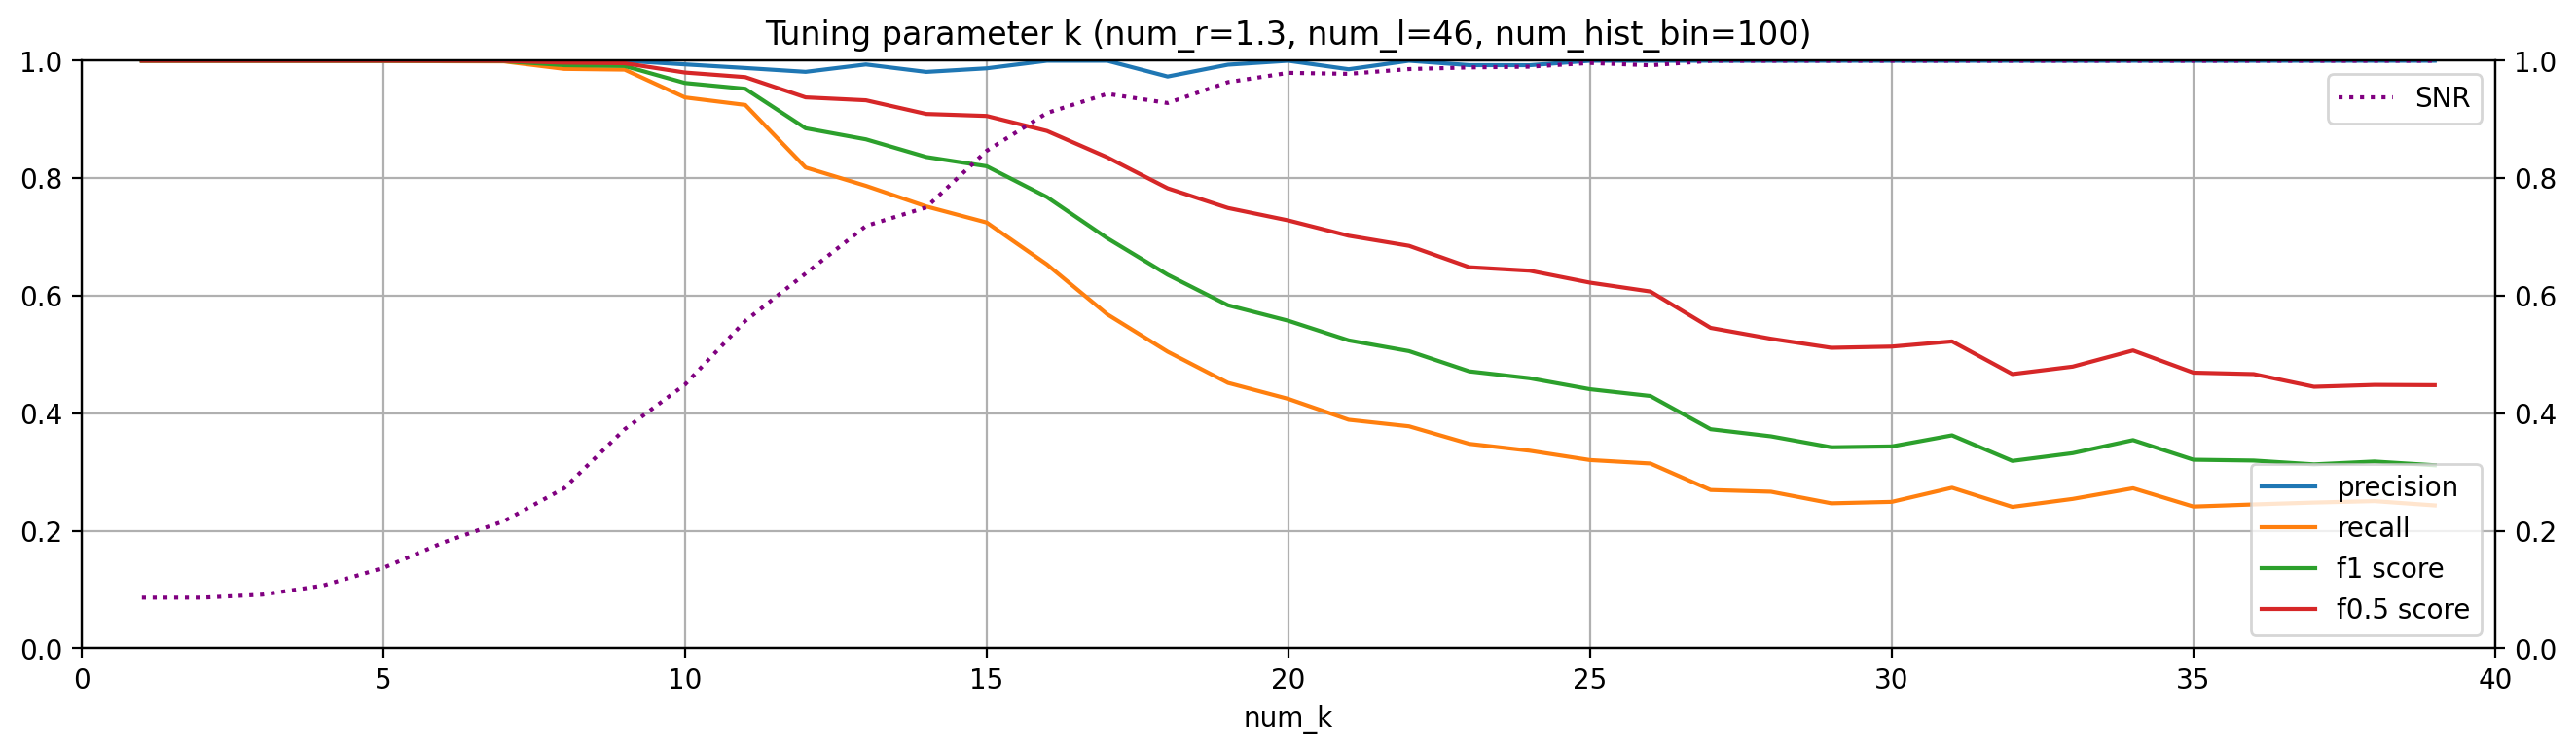

In [42]:
fig, ax1 = plt.subplots(figsize=(16,4), dpi=200)

x = k_range

ax1.plot(x, preci, label='precision')
ax1.plot(x, recall, label='recall')
ax1.plot(x, f1, label='f1 score')
ax1.plot(x, f05, label='f0.5 score')

ax1.set_xlabel('num_k')
ax1.legend(loc=4)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_xlim(0,40)

ax2 = ax1.twinx()
ax2.plot(x, snr, label='SNR', color='purple', linestyle=':')
ax2.set_ylim(0, 1)
ax2.legend(loc=1)         

plt.title('Tuning parameter k (num_r=1.3, num_l=46, num_hist_bin=100)')
plt.show()
# fig.savefig('4_b.eps',dpi=300,format='eps')

## Tunning parameter L

In [43]:
preci = []
recall = []
f1 = []
f05 = []
snr = []

l_range = np.arange(10, 100, 1)

for l in tqdm(l_range, leave=False):

    lsh = l2lsh_with_data(bins=100, r=1.3, num_k=11, num_l=l, data=data, seed=10)      

    # Query
    actual_result = defaultdict(set)    
    single_query_snr = 0
    
    for q in data.keys():          
        q_prob = utils.data_to_probability(data[q], bins=bins)
        q_sq_prob = np.sqrt(q_prob).reshape(-1, 1)
        query_result = lsh.query(q_sq_prob, threshold=0)
        # Remove itself
        query_result.remove(q)      
        # Manually validate the JS-Divergence to avoid false positive
        for c in query_result:
            c_prob = utils.data_to_probability(data[c], bins)
            if utils.jensen_shannon_divergence(q_prob, c_prob) < 0.1:
                actual_result[q].add(c)       
        
        single_query_snr += len(actual_result[q]) / len(query_result) if len(query_result) != 0 else 1   
    
    performance_matrix = utils.evaluation(actual_result, expect_result)
    preci.append(performance_matrix[0])
    recall.append(performance_matrix[1])
    f1.append(performance_matrix[2])
    f05.append(performance_matrix[3])
    snr.append(single_query_snr / len(data.keys()))

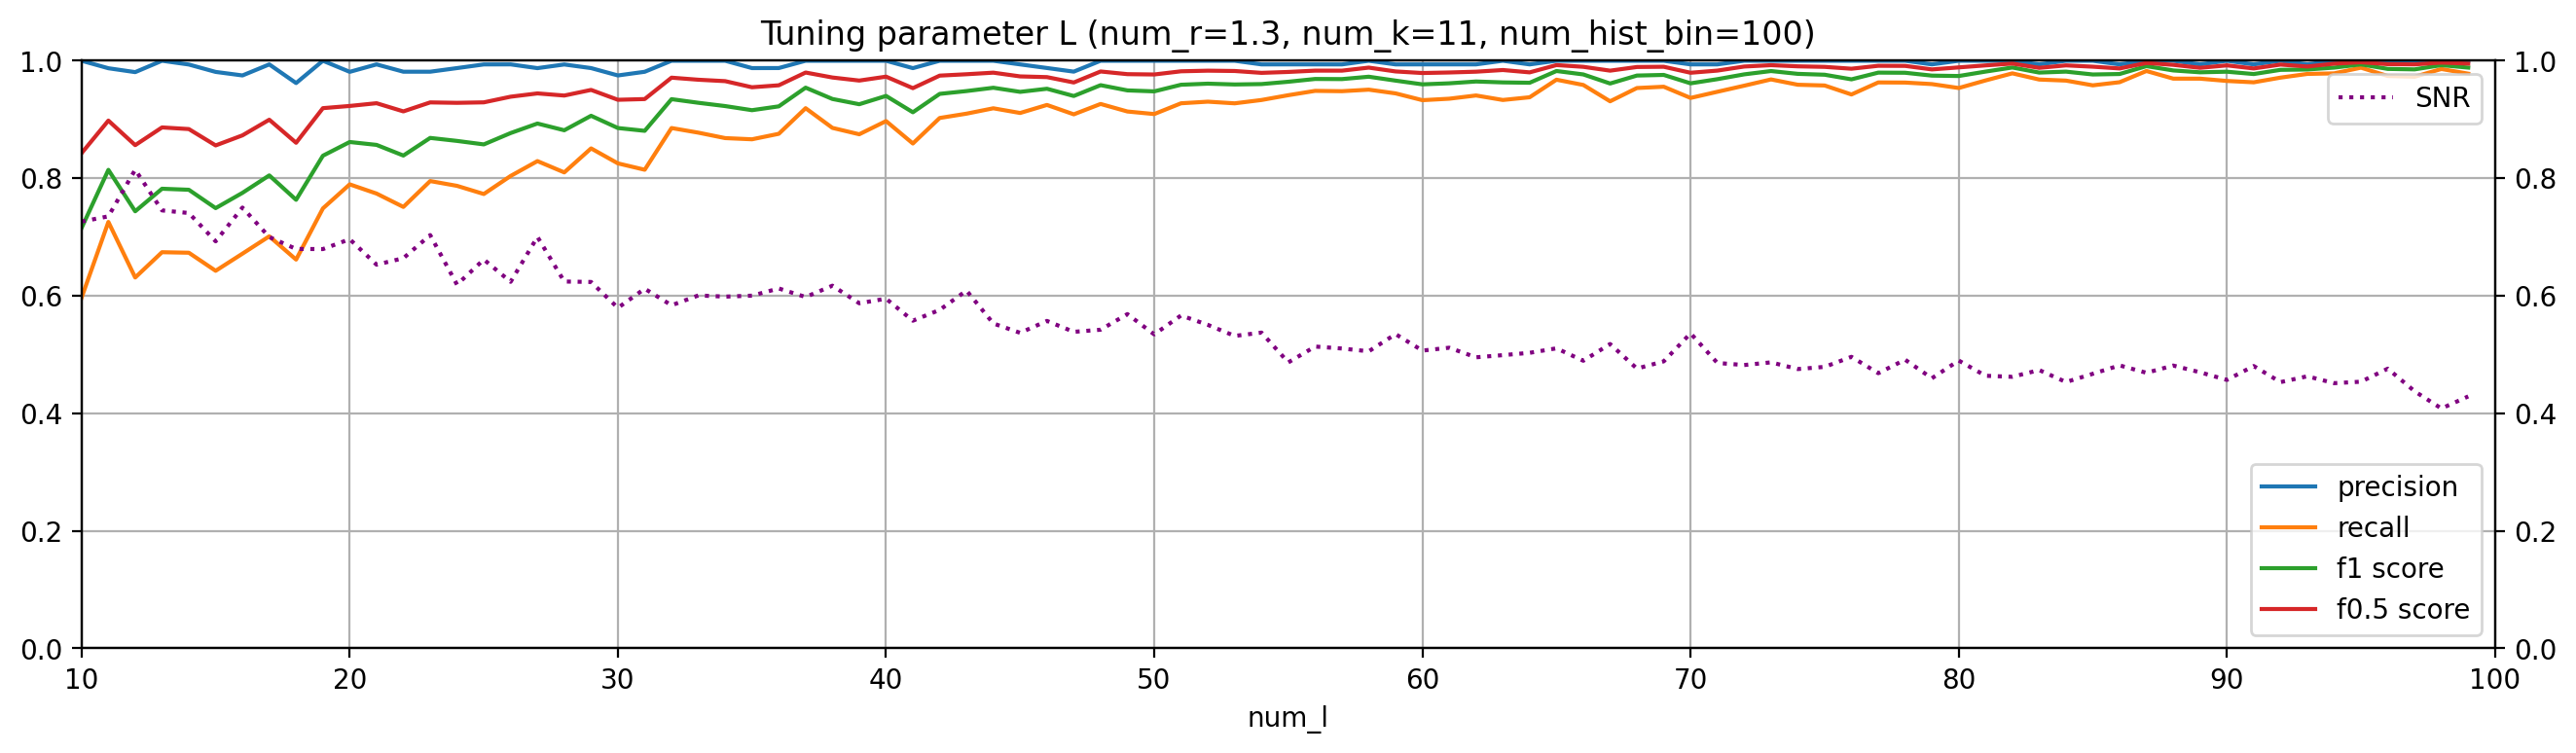

In [44]:
fig, ax1 = plt.subplots(figsize=(16,4), dpi=200)

x = l_range

ax1.plot(x, preci, label='precision')
ax1.plot(x, recall, label='recall')
ax1.plot(x, f1, label='f1 score')
ax1.plot(x, f05, label='f0.5 score')

ax1.set_xlabel('num_l')
ax1.legend(loc=4)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_xlim(10,100)

ax2 = ax1.twinx()
ax2.plot(x, snr, label='SNR', color='purple', linestyle=':')
ax2.set_ylim(0, 1)
ax2.legend(loc=1)         

plt.title('Tuning parameter L (num_r=1.3, num_k=11, num_hist_bin=100)')
plt.show()
# fig.savefig('4_c.eps',dpi=300,format='eps')

## Tunning parameter bins

In [45]:
preci = []
recall = []
f1 = []
f05 = []
snr = []

bins_range = np.arange(5, 400, 1)

for bins in tqdm(bins_range, leave=False):

    lsh = l2lsh_with_data(bins=bins, r=1.3, num_k=11, num_l=46, data=data, seed=10)      

    # Query
    actual_result = defaultdict(set)    
    single_query_snr = 0
    
    for q in data.keys():          
        q_prob = utils.data_to_probability(data[q], bins=bins)
        q_sq_prob = np.sqrt(q_prob).reshape(-1, 1)
        query_result = lsh.query(q_sq_prob, threshold=0)
        # Remove itself
        query_result.remove(q)      
        # Manually validate the JS-Divergence to avoid false positive
        for c in query_result:
            c_prob = utils.data_to_probability(data[c], bins)
            if utils.jensen_shannon_divergence(q_prob, c_prob) < 0.1:
                actual_result[q].add(c)       
        
        single_query_snr += len(actual_result[q]) / len(query_result) if len(query_result) != 0 else 1   
    
    performance_matrix = utils.evaluation(actual_result, expect_result)
    preci.append(performance_matrix[0])
    recall.append(performance_matrix[1])
    f1.append(performance_matrix[2])
    f05.append(performance_matrix[3])
    snr.append(single_query_snr / len(data.keys()))

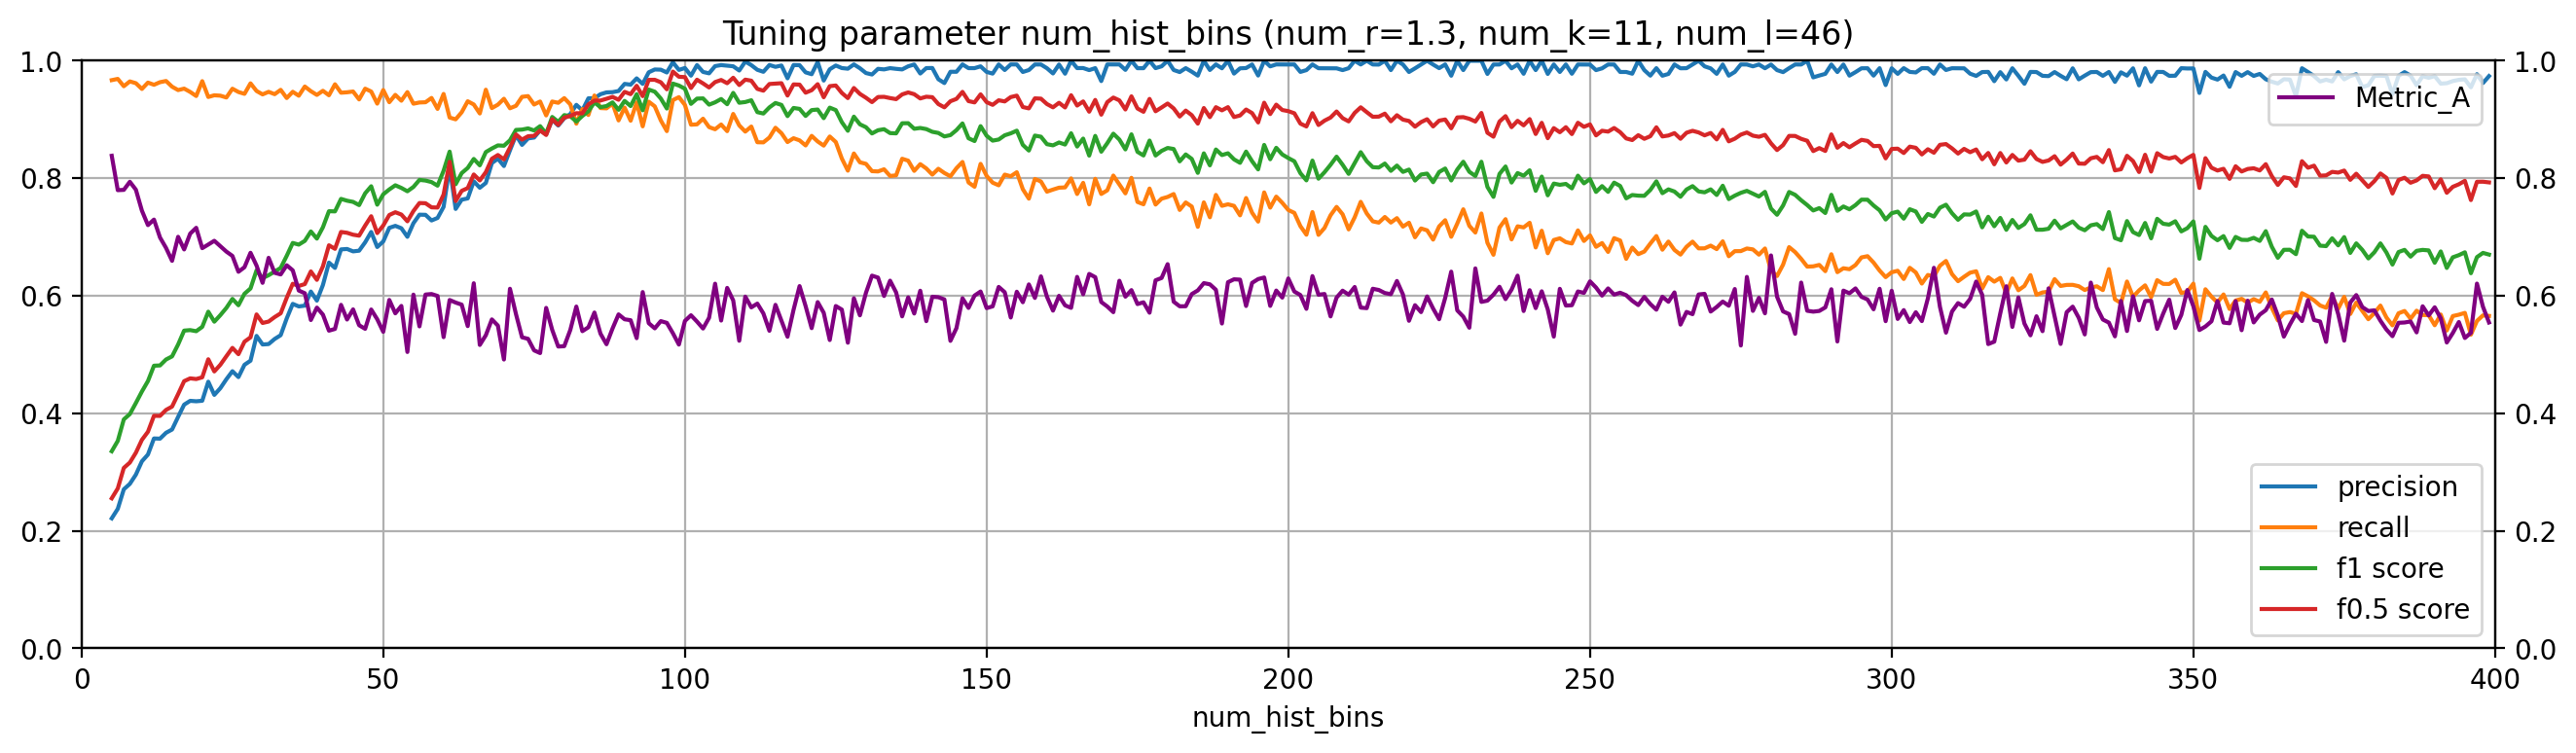

In [46]:
fig, ax1 = plt.subplots(figsize=(16,4), dpi=200)

x = bins_range

ax1.plot(x, preci, label='precision')
ax1.plot(x, recall, label='recall')
ax1.plot(x, f1, label='f1 score')
ax1.plot(x, f05, label='f0.5 score')

ax1.set_xlabel('num_hist_bins')
ax1.legend(loc=4)
ax1.grid()
ax1.set_ylim(0,1)
ax1.set_xlim(0,400)

ax2 = ax1.twinx()
ax2.plot(x, snr, label='Metric_A', color='purple', linestyle='-')
ax2.set_ylim(0, 1)
ax2.legend(loc=1)         

plt.title('Tuning parameter num_hist_bins (num_r=1.3, num_k=11, num_l=46)')
plt.show()
# fig.savefig('4_d.eps',dpi=300,format='eps')

## Multiple hyper parameter search

In [ ]:
r_range = np.arange(0.001, 1, 0.01)
k_range = np.arange(1, 30, 1)
l_range = np.arange(10, 70, 1)
bins = 100

parameter_combination = list(product(r_range, k_range, l_range))


preci = []
recall = []
f1 = []
f05 = []
snr = []

for params in tqdm(parameter_combination):
    r = params[0]
    k = params[1]
    l = params[2]
    
    lsh = l2lsh_with_data(bins=bins, r=r, num_k=k, num_l=l, data=data, seed=10)      

    # Query
    actual_result = defaultdict(set)    
    single_query_snr = 0
    
    for q in data.keys():          
        q_prob = data_to_prob(data=data, key=q, bins=bins)
        q_sq_prob = np.sqrt(q_prob).reshape(-1, 1)
        query_result = lsh.query(q_sq_prob, threshold=0)
        # Remove itself
        query_result.remove(q)      
        
        for c in query_result:
            c_prob = data_to_prob(data, c, bins)
            if utils.jensen_shannon_divergence(q_prob, c_prob) < 0.1:
                actual_result[q].add(c)       
        
        single_query_snr += len(actual_result[q]) / len(query_result) if len(query_result) != 0 else 1   
    
    performance_matrix = utils.evaluation(actual_result, expect_result)
    preci.append(performance_matrix[0])
    recall.append(performance_matrix[1])
    f1.append(performance_matrix[2])
    f05.append(performance_matrix[3])
    snr.append(single_query_snr / len(data.keys()))

## Trade off between performance and accuracy

In [48]:
# Baseline - Compute JS-Divergence by pair-wise

tf_baseline_expect_result = defaultdict(set)
tf_baseline_bins = 100
tf_baseline_loops = 5

# Performance trade off
tf_baseline_query_time = []
t1 = my_timer.Timer()

for d1 in tqdm(data.keys(), leave=False):    
    t1.tic()
    for _ in range(tf_baseline_loops):    
        prob1 = utils.data_to_probability(data[d1], tf_baseline_bins)
        for d2 in data.keys():
            if d1 == d2:
                continue            
            prob2 = utils.data_to_probability(data[d2], tf_baseline_bins)
            jsd = utils.jensen_shannon_divergence(prob1, prob2)            
            if jsd < 0.1:
                tf_baseline_expect_result[d1].add(d2)
            
    tf_baseline_query_time.append(t1.toc() / tf_baseline_loops)

In [50]:
tf_lsh_actual_result = defaultdict(set)
tf_lsh_bins = 100
tf_lsh_loops = 5

tf_lsh_query_time = []
tf_lsh_compute_time = []
tf_lsh_candidate_select_time = []


lsh = l2lsh_with_data(tf_lsh_bins, 1.3, 11, 46, data)

# Query
t1 = my_timer.Timer()
t2 = my_timer.Timer() # Compute LSH and retrive candidates timer
t3 = my_timer.Timer() # Select candidate timer

for q in tqdm(data.keys(), leave=False):
    t1.tic()
    temp_t2 = 0
    temp_t3 = 0
    for _ in  range(tf_lsh_loops):
        
        t2.tic()
        q_prob = utils.data_to_probability(data[q], tf_lsh_bins)
        q_sq_prob = np.sqrt(q_prob).reshape(-1,1)
        
        query_result = lsh.query(q_sq_prob, threshold=0)
        query_result.remove(q)
        
        temp_t2 += t2.toc()
        
        t3.tic()
        
        for c in query_result:
            c_prob = utils.data_to_probability(data[c], tf_lsh_bins)
            
            if utils.jensen_shannon_divergence(q_prob, c_prob) < 0.1:
                tf_lsh_actual_result[q].add(c)
        
        temp_t3 += t3.toc()
    
    tf_lsh_query_time.append(t1.toc()/tf_lsh_loops)
    tf_lsh_compute_time.append(temp_t2 / tf_lsh_loops)
    tf_lsh_candidate_select_time.append(temp_t3 / tf_lsh_loops)
    temp_t2 = 0
    temp_t3 = 0

In [51]:
# Accuracy metrics for each query
tf_lsh_list_precision = []
tf_lsh_list_recall = []

for k in data.keys():
    precision, recall = utils.accuracy_metrics(tf_lsh_actual_result[k], tf_baseline_expect_result[k])
    
    tf_lsh_list_precision.append(precision)
    tf_lsh_list_recall.append(recall)

tf_lsh_evaluation_metrics = utils.evaluation(tf_lsh_actual_result, tf_baseline_expect_result)

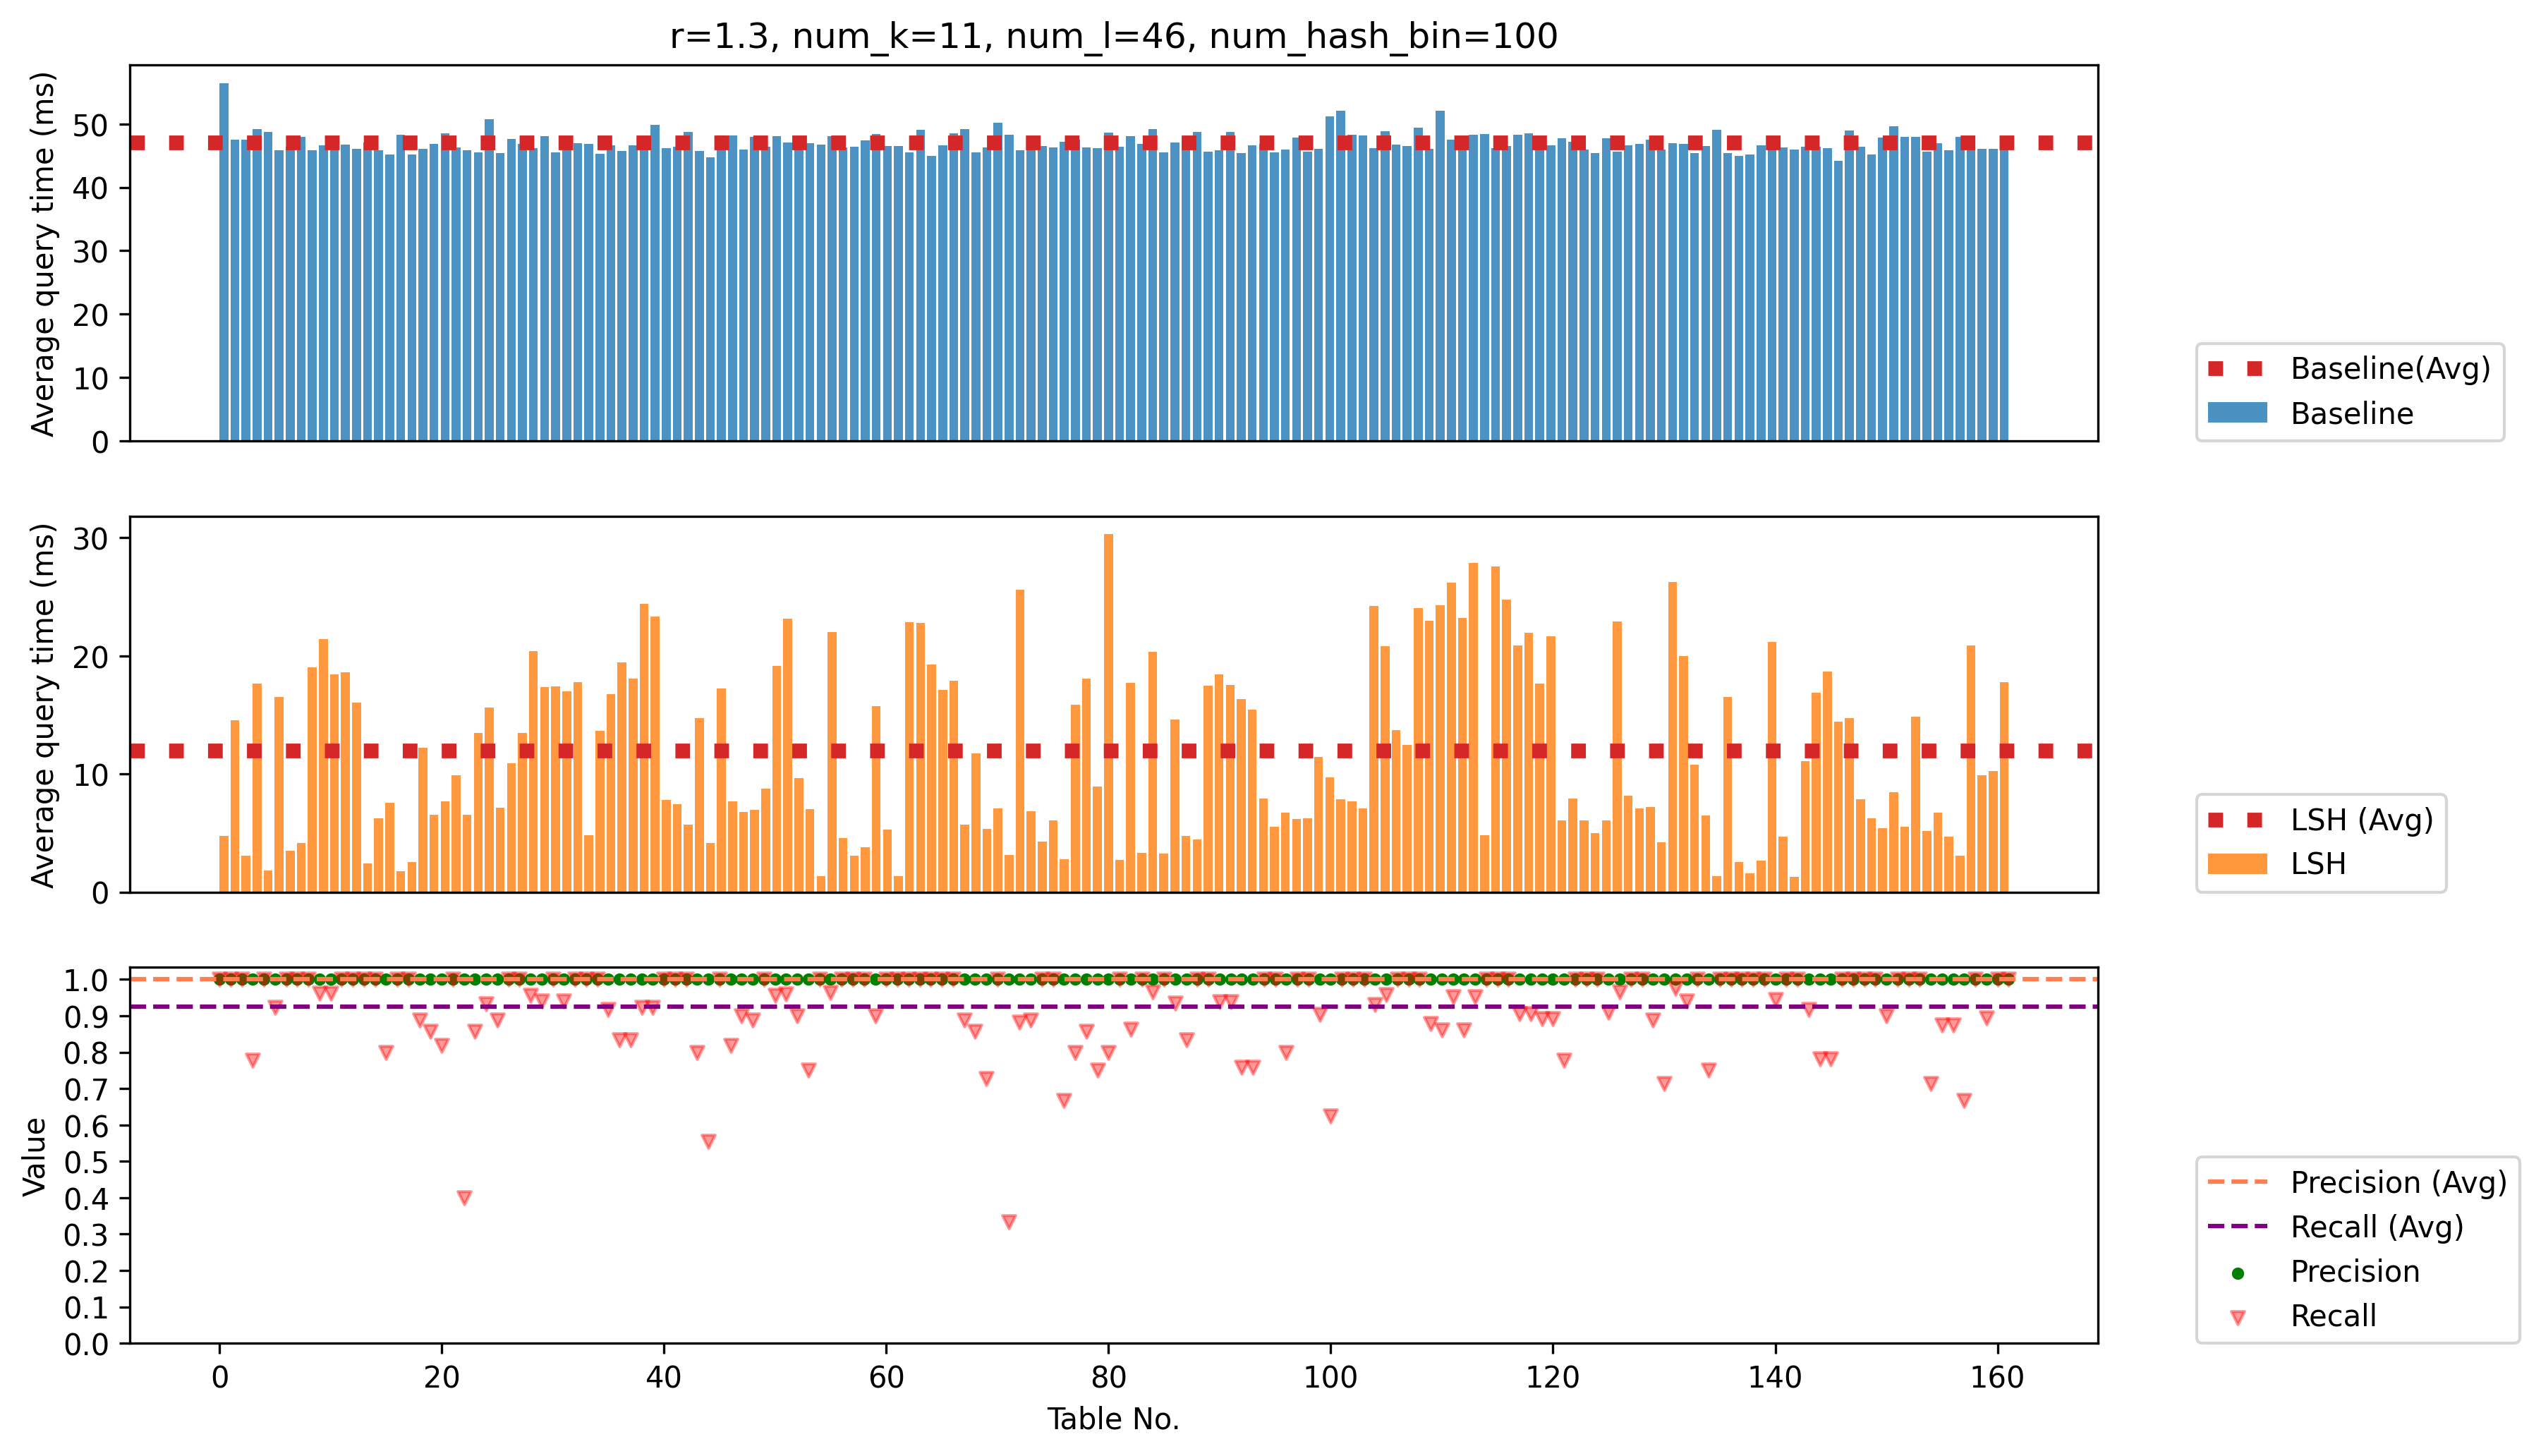

In [52]:
fig = plt.figure(figsize=(12,8), dpi=300)
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 3, 3])

ax0 = plt.subplot(gs[0])

x = np.arange(0, len(tf_baseline_query_time))

ax0.bar(x, tf_baseline_query_time, label='Baseline', width=0.8, alpha=0.8)

ax0.axhline(np.average(tf_baseline_query_time), label='Baseline(Avg)', color='tab:red', linestyle=':', linewidth=5)


ax0.legend(loc=(1.05, 0))
ax0.set_ylabel('Average query time (ms)')
ax0.set_title('r=1.3, num_k=11, num_l=46, num_hash_bin=100')

plt.xticks([])


ax1 = plt.subplot(gs[1])
# ax1.bar(x, tf_lsh_compute_time, label='LSH Query', width=0.8, alpha=0.8, color='tab:orange')
# ax1.bar(x, tf_lsh_candidate_select_time, label='Select From Candidate', width=0.8, alpha=0.8, color='tab:blue', bottom=tf_lsh_compute_time)
ax1.bar(x, tf_lsh_query_time, label='LSH', width=0.8, alpha=0.8, color='tab:orange')
ax1.axhline(np.average(tf_lsh_query_time), label='LSH (Avg)', color='tab:red', linestyle=':', linewidth=5)
ax1.legend(loc=(1.05, 0))
ax1.set_ylabel('Average query time (ms)')
plt.xticks([])


ax2 = plt.subplot(gs[2])
ax2.scatter(x, tf_lsh_list_precision, label='Precision', color='green', s=10, alpha=1)
ax2.scatter(x, tf_lsh_list_recall, label='Recall', color='red', s=20, alpha=0.4, marker='v')
ax2.axhline(y=tf_lsh_evaluation_metrics[0], label='Precision (Avg)', linestyle='--', color='coral')
ax2.axhline(y=tf_lsh_evaluation_metrics[1], label='Recall (Avg)', linestyle='--', color='purple')
ax2.set_ylabel('Value')
ax2.legend(loc=(1.05, 0))
plt.yticks(np.arange(0, 1.01, 0.1))

plt.xlabel('Table No.')
plt.show()
# fig.savefig('3.eps',dpi=300,format='eps',bbox_inches='tight')

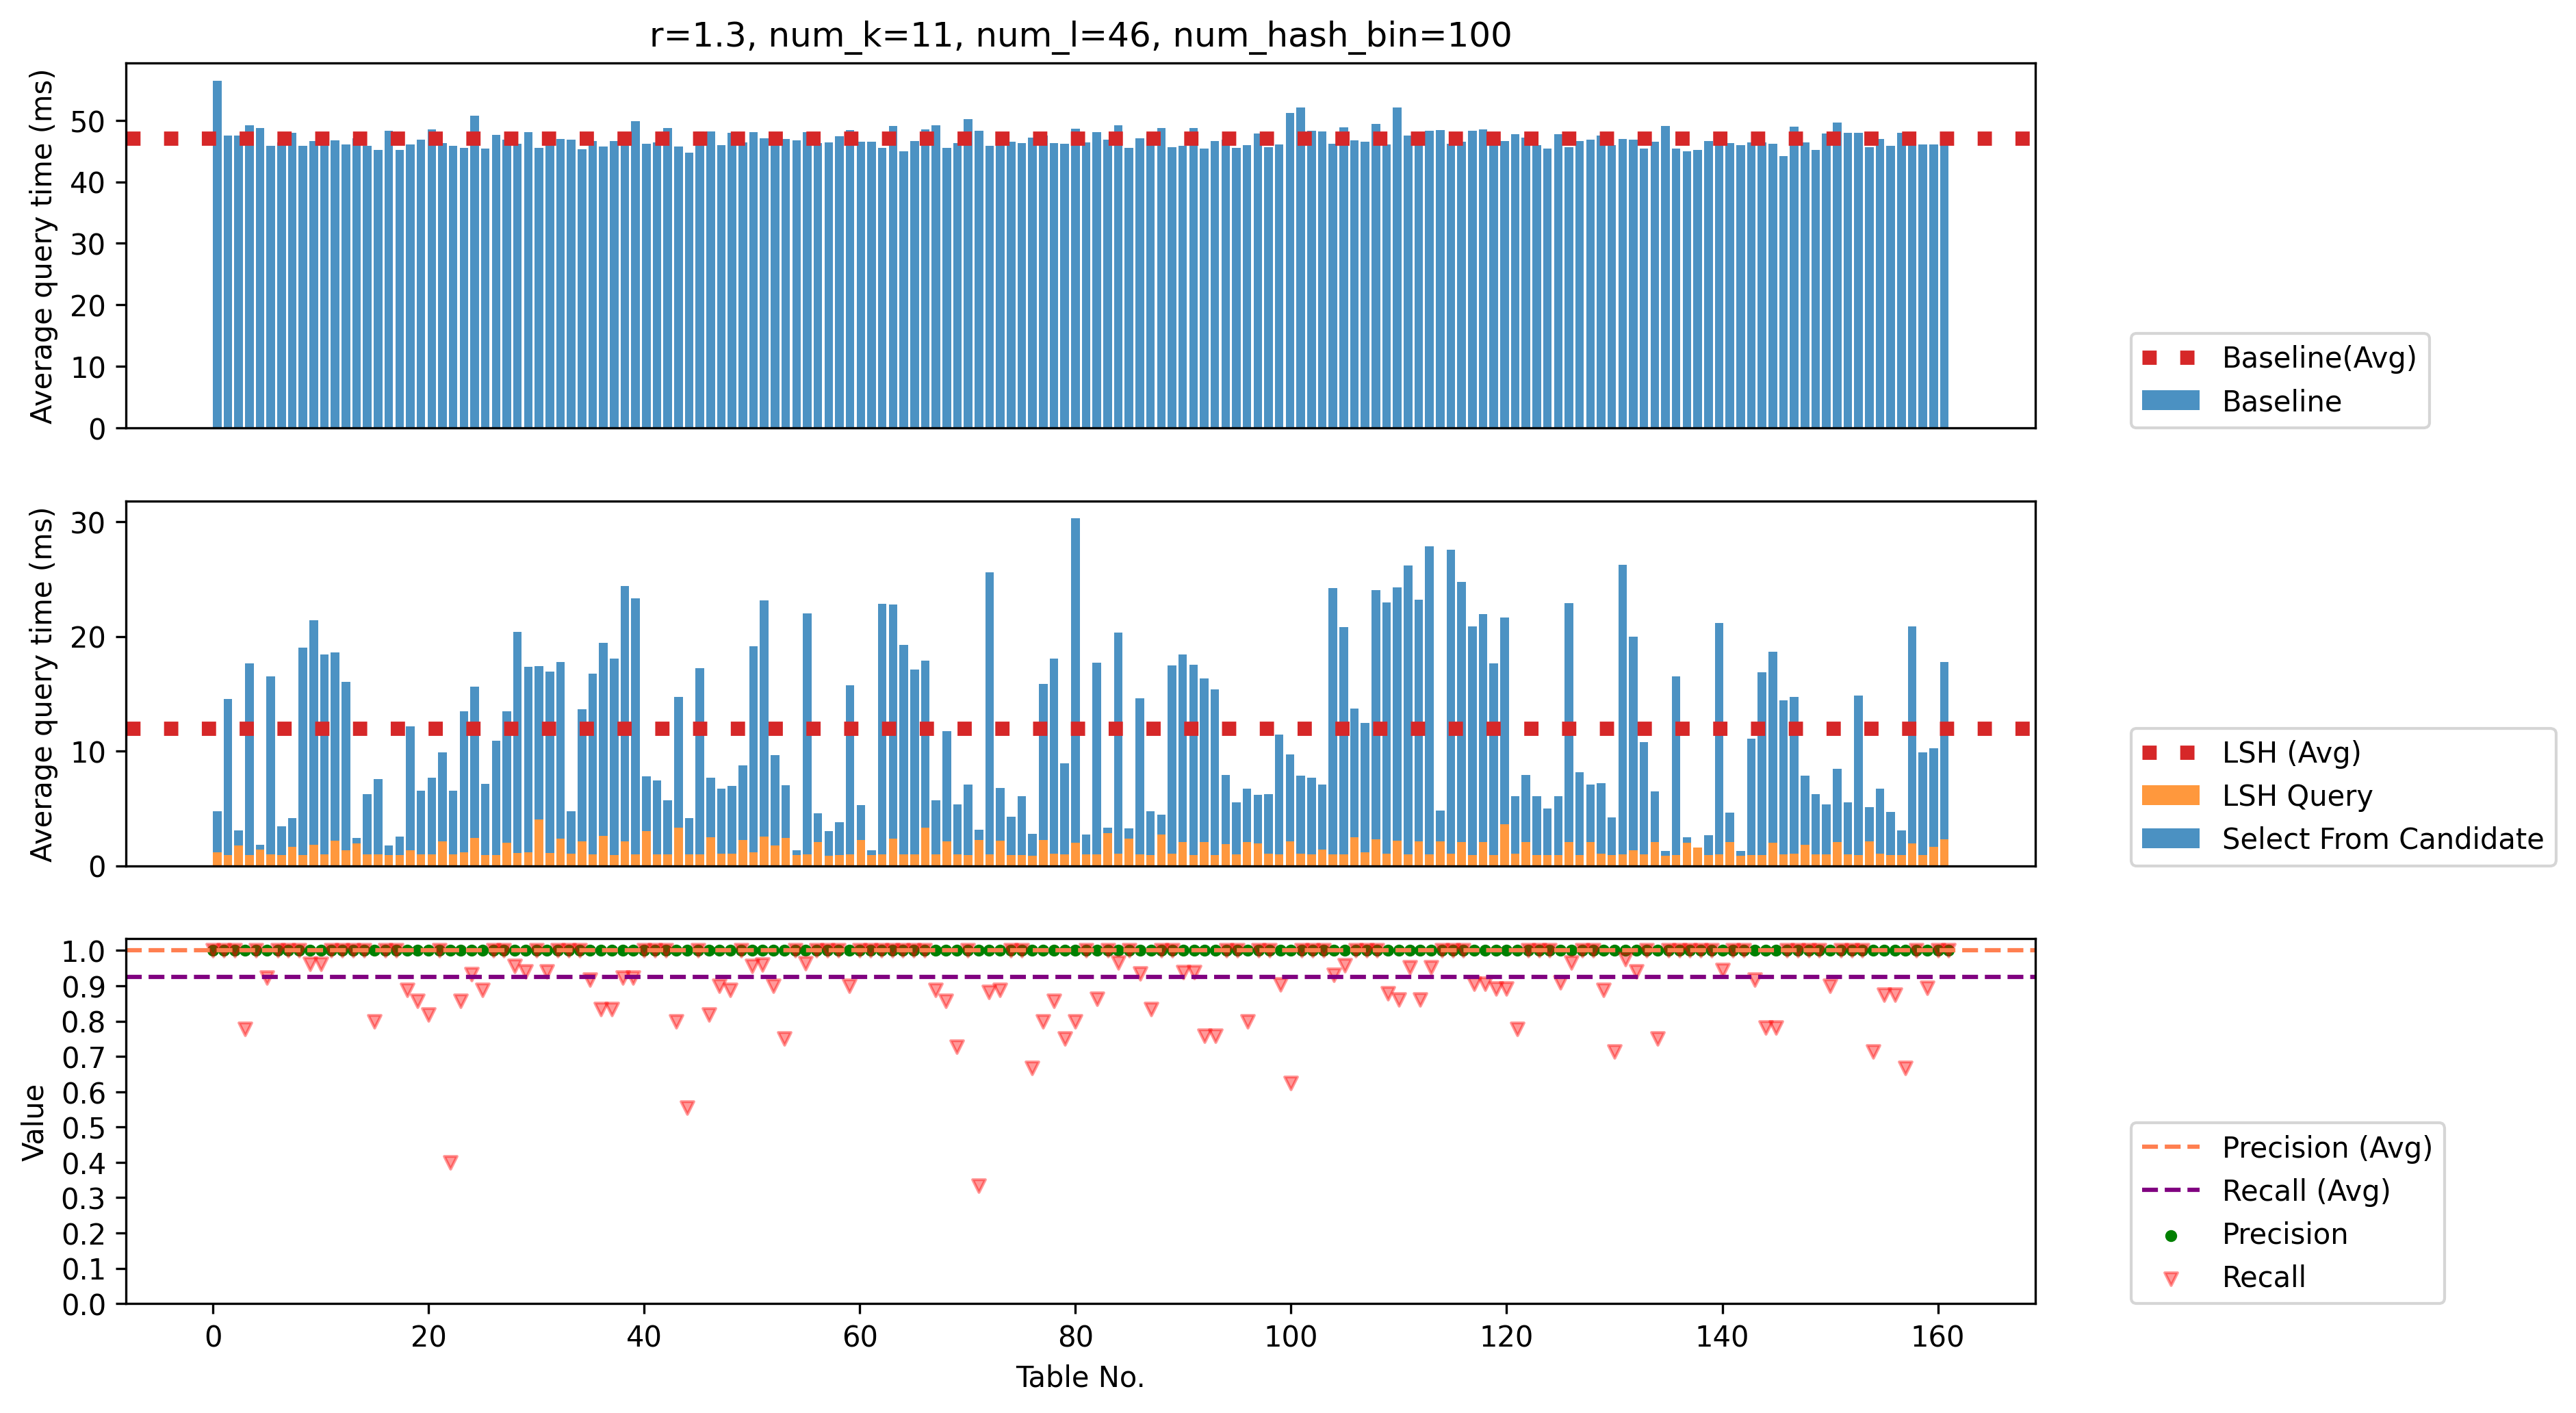

In [53]:
fig = plt.figure(figsize=(12,8), dpi=300)
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 3, 3])

ax0 = plt.subplot(gs[0])

x = np.arange(0, len(tf_baseline_query_time))

ax0.bar(x, tf_baseline_query_time, label='Baseline', width=0.8, alpha=0.8)

ax0.axhline(np.average(tf_baseline_query_time), label='Baseline(Avg)', color='tab:red', linestyle=':', linewidth=5)


ax0.legend(loc=(1.05, 0))
ax0.set_ylabel('Average query time (ms)')
ax0.set_title('r=1.3, num_k=11, num_l=46, num_hash_bin=100')

plt.xticks([])


ax1 = plt.subplot(gs[1])
ax1.bar(x, tf_lsh_compute_time, label='LSH Query', width=0.8, alpha=0.8, color='tab:orange')
ax1.bar(x, tf_lsh_candidate_select_time, label='Select From Candidate', width=0.8, alpha=0.8, color='tab:blue', bottom=tf_lsh_compute_time)
# ax1.bar(x, tf_lsh_query_time, label='LSH', width=0.8, alpha=0.8, color='tab:orange')
ax1.axhline(np.average(tf_lsh_query_time), label='LSH (Avg)', color='tab:red', linestyle=':', linewidth=5)
ax1.legend(loc=(1.05, 0))
ax1.set_ylabel('Average query time (ms)')
plt.xticks([])


ax2 = plt.subplot(gs[2])
ax2.scatter(x, tf_lsh_list_precision, label='Precision', color='green', s=10, alpha=1)
ax2.scatter(x, tf_lsh_list_recall, label='Recall', color='red', s=20, alpha=0.4, marker='v')
ax2.axhline(y=tf_lsh_evaluation_metrics[0], label='Precision (Avg)', linestyle='--', color='coral')
ax2.axhline(y=tf_lsh_evaluation_metrics[1], label='Recall (Avg)', linestyle='--', color='purple')
ax2.set_ylabel('Value')
ax2.legend(loc=(1.05, 0))
plt.yticks(np.arange(0, 1.01, 0.1))

plt.xlabel('Table No.')
plt.show()
# fig.savefig('3.eps',dpi=300,format='eps',bbox_inches='tight')